In [1]:
from PIL import Image
import os, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
folder = './fifty_reso_data/train'
filelist=os.listdir(folder)
for fichier in filelist:
    if not(fichier.endswith(".png")):
        filelist.remove(fichier)
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
ims = [read(os.path.join(folder, filename)) for filename in filelist]
im_array = np.array(ims, dtype='uint8')
im_array = im_array / 255.0

In [4]:
X_train, X_test = train_test_split(im_array, test_size=0.1, random_state=42)

In [18]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(2*code_size))
    encoder.add(Dense(code_size))
    

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Dense(np.prod(img_shape))) 
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [19]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = im_array.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 32)                241088    
_________________________________________________________________
sequential_6 (Sequential)    (None, 50, 50, 3)         56505000  
Total params: 56,746,088
Trainable params: 56,746,088
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
IMG_SHAPE 

(50, 50, 3)

In [ ]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

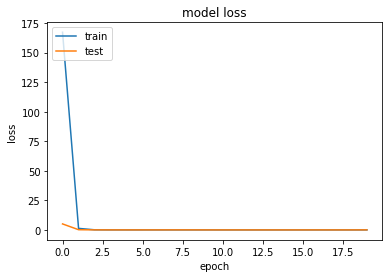

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

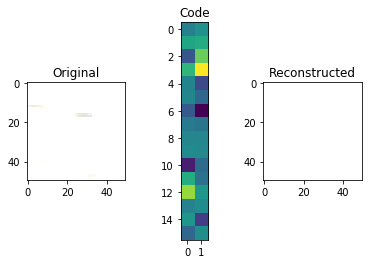

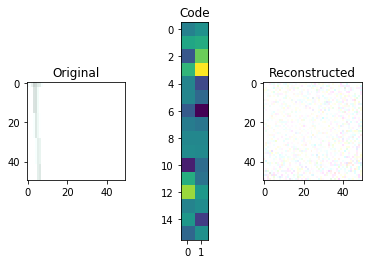

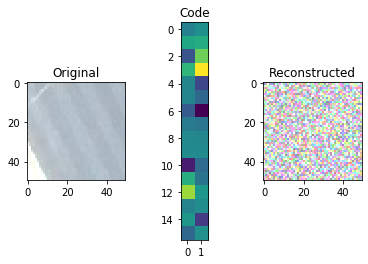

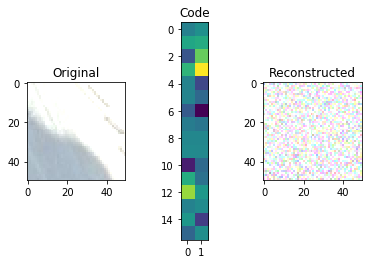

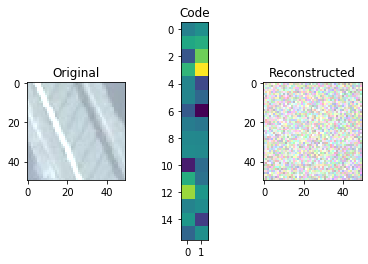

In [17]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    #print(img[None][0])
    visualize(img,encoder,decoder)